In [1]:
from decimal import Decimal
import json
from decimal import InvalidOperation

objs = []
root = '/Users/rivers/Desktop/nice datasets/MOBA/'
data_root = root+'matches/'
save_root = root+'Topics/Bursty/intermediate/'
graph_root = root+'Topics/Bursty/results/'
game_mode = -1

mode_dict = {-1: 'captainrank', 22: 'rank',1:'allpick',5:'allrandom'}

# Custom JSON decoder function to convert strings back to Decimal
def decimal_decoder(obj):
    for key, value in obj.items():
        if isinstance(value, str):  # Ensure the value is a string
            try:
                # Attempt to convert strings that look like Decimals back to Decimal objects
                obj[key] = Decimal(value)
            except InvalidOperation:
                pass  # Skip conversion if the value cannot be converted to Decimal
    return obj

# Read the list of dictionaries back from the JSON file
with open(data_root+'%s_matches_2000.json'%(mode_dict[game_mode]), 'r') as file:
    objs = json.load(file, object_hook=decimal_decoder)

In [3]:
def calculate_differences(int_list):
    # Ensure the list has at least 2 elements
    if len(int_list) < 2:
        raise ValueError("The list must contain at least 2 elements.")

    # Calculate the differences between consecutive elements
    differences = [int_list[i+1] - int_list[i] for i in range(len(int_list) - 1)]
    
    return differences

def chats_of(slot,chat):
    t = []
    l = []
    for chat_line in chat:
        #print(chat_line)
        if 'slot' in list(chat_line.keys()):
            if chat_line['slot'] == slot:
                t.append(chat_line['time'])
                l.append(len(str(chat_line['key'])))
    if len(t) > 1:
        t_diff = calculate_differences(t)
        t_diff.insert(0,0)
    
        return l, t_diff
    else:
        return [],[]


In [4]:
# Team 

modes = list(mode_dict.keys())
slots = list(range(10))

team_t, team_l, ind_t, ind_l= {}, {}, {}, {}

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:

        objs = json.load(file, object_hook=decimal_decoder)

        
    team_t_sample, team_l_sample, ind_t_sample, ind_l_sample = [], [], [], []
    for obj in objs:
        if (mode == 2 and obj['lobby_type'] == 7) or mode != 2:
            time = []
            if len(obj['chat']) > 1:
                for chat_line in obj['chat']:
                    time.append(chat_line['time'])
                    
                    team_l_sample.append(len(str(chat_line['key'])))
                
                diff = calculate_differences(time)
                diff.insert(0,0)
                team_t_sample += diff
            
            for slot in slots:
                l, t_diff = chats_of(slot, obj['chat'])
                ind_t_sample += t_diff
                ind_l_sample += l
    
    team_t[mode], team_l[mode], ind_l[mode], ind_t[mode] = team_t_sample, team_l_sample, ind_l_sample, ind_t_sample


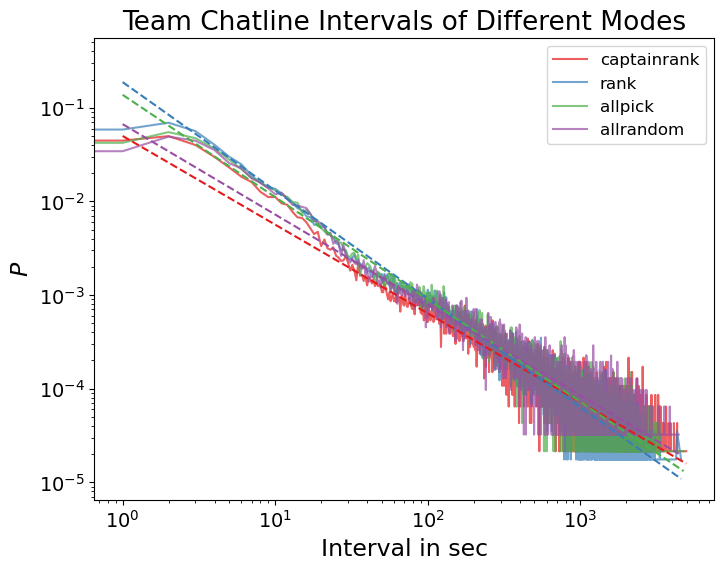

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Define color palette
palette = sns.color_palette("Set1")

# Dictionary to store processed data
ind = {}
t = ind_t # ind_t/ team_t
# Process each mode's t_sample in ind_t
for i, mode in enumerate(t.keys()):  
    dist = Counter(t[mode])  # Count occurrences in the current sample
    x, y = [], []
    
    for interval in sorted(dist):   
        x.append(interval)
        y.append(dist[interval] / sum(dist.values()))  # Normalize using total count
    
    ind[mode] = (x, y)  # Store in dictionary

# Plot raw data
plt.figure(figsize=(8, 6))
for i, (mode, (x, y)) in enumerate(ind.items()):
    plt.plot(x, y, label=mode_dict[mode], color=palette[i], alpha=0.7)

# Fit power-law lines
for i, (mode, (x, y)) in enumerate(ind.items()):
    x = np.array(x)
    y = np.array(y)
    
    # Avoid log issues by replacing zeros
    x = np.where(x == 0, 1, x)
    y = np.where(y == 0, 1, y)

    # Fit a power-law in log-log space
    coeffs = np.polyfit(np.log(x), np.log(y), 1)
    fitted_line = np.exp(coeffs[1]) * x ** coeffs[0]

    # Plot fitted line
    plt.plot(x, fitted_line, linestyle='--', color=palette[i])

# Labels, scales, and legend
plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P$', fontsize=17)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Team Chatline Intervals of Different Modes', fontsize=19)
plt.legend(fontsize=12)

# Save and show plot
# plt.savefig(graph_root+'team_power_law_fit.pdf')
plt.show()

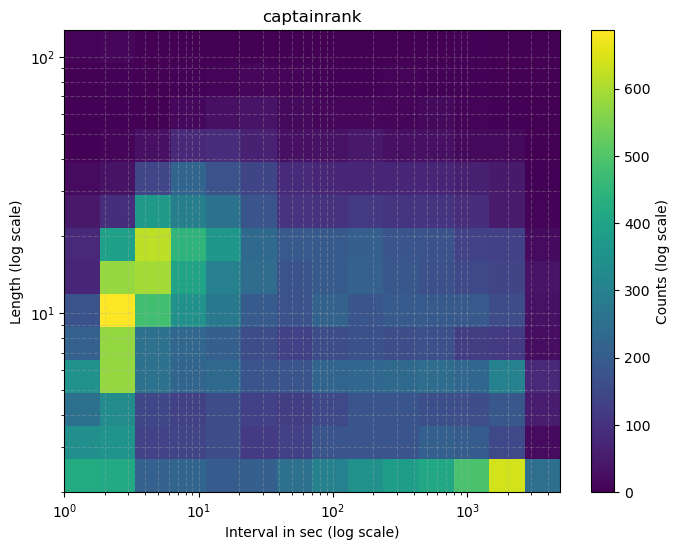

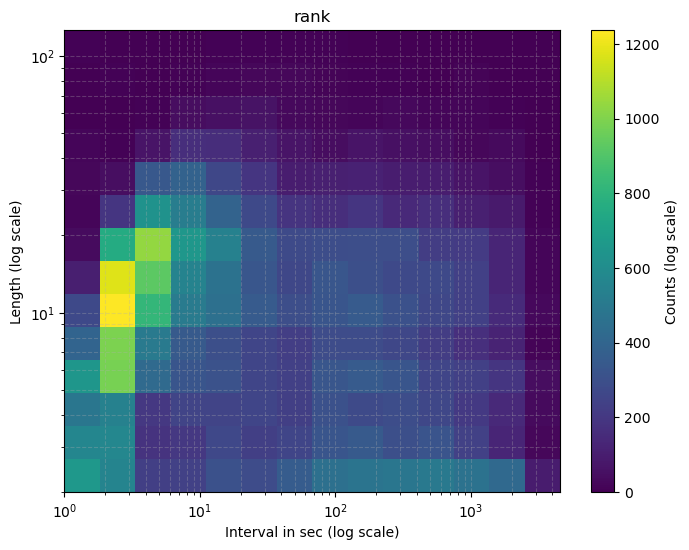

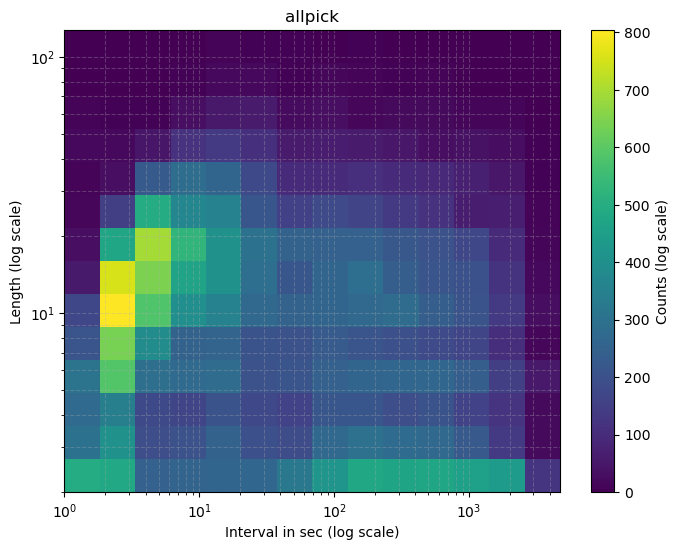

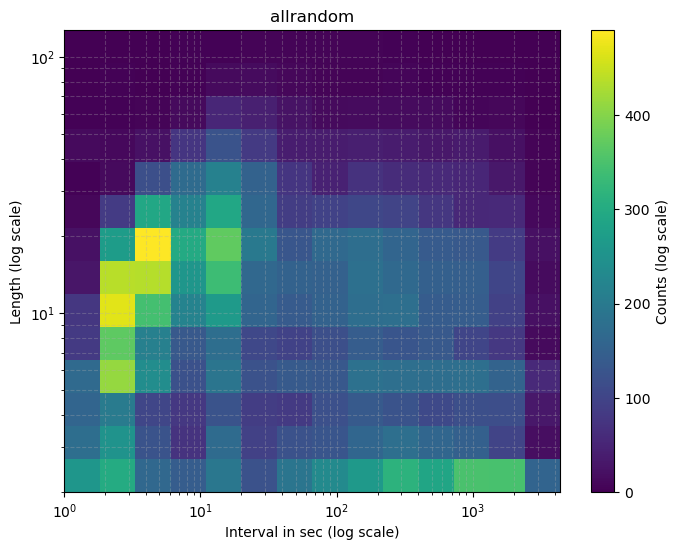

In [ ]:
import matplotlib.colors as mcolors
import numpy as np
for mode in modes:

    t_sample = ind_t[mode]
    l_sample = ind_l[mode]
    x_bins = np.logspace(np.log10(min(t_sample) + 1), np.log10(max(t_sample)), 15)
    y_bins = np.logspace(np.log10(min(l_sample) + 1), np.log10(max(l_sample)), 15)

    # Create 2D histogram data
    heatmap, xedges, yedges = np.histogram2d(t_sample, l_sample, bins=[x_bins, y_bins])

    # Plot the heatmap with a logarithmic color scale
    plt.figure(figsize=(8, 6))

    #bounds = np.linspace(0, 1000, 200)
    #norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

    plt.pcolormesh(
        xedges, yedges, heatmap.T, shading='auto', cmap='viridis',
      #  norm=mcolors.LogNorm(vmin=1, vmax=3000)
    )
    plt.colorbar(label='Counts (log scale)')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Length (log scale)')
    plt.xlabel('Interval in sec (log scale)')
    plt.title(mode_dict[(mode)])
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.savefig(graph_root+'/heatmap_ind_tVl_%s.pdf'%(mode_dict[mode]))
    plt.show()

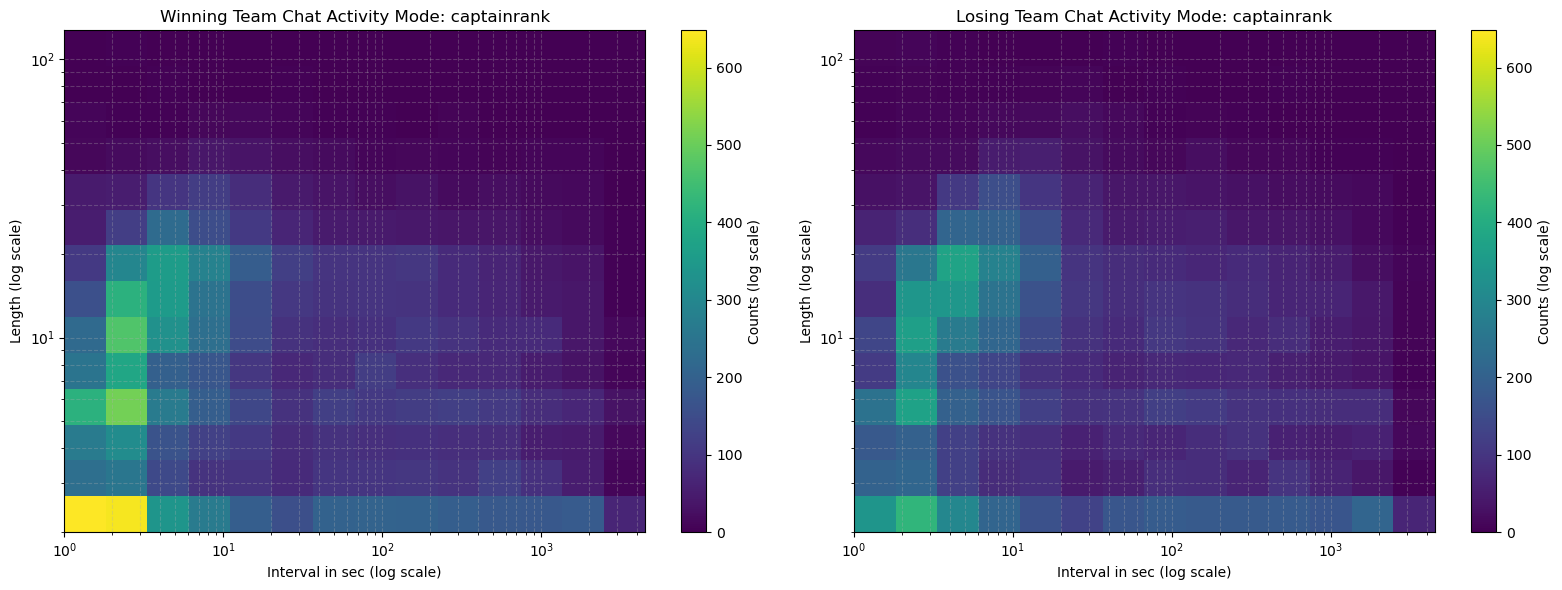

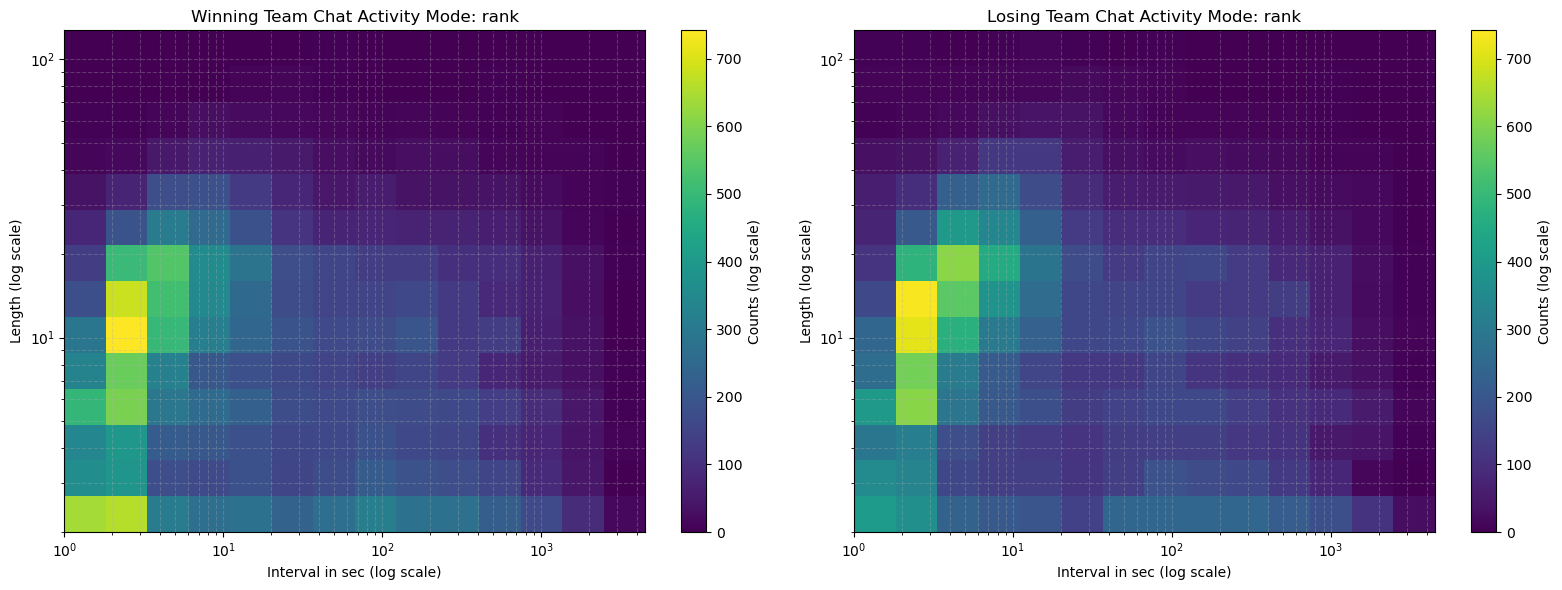

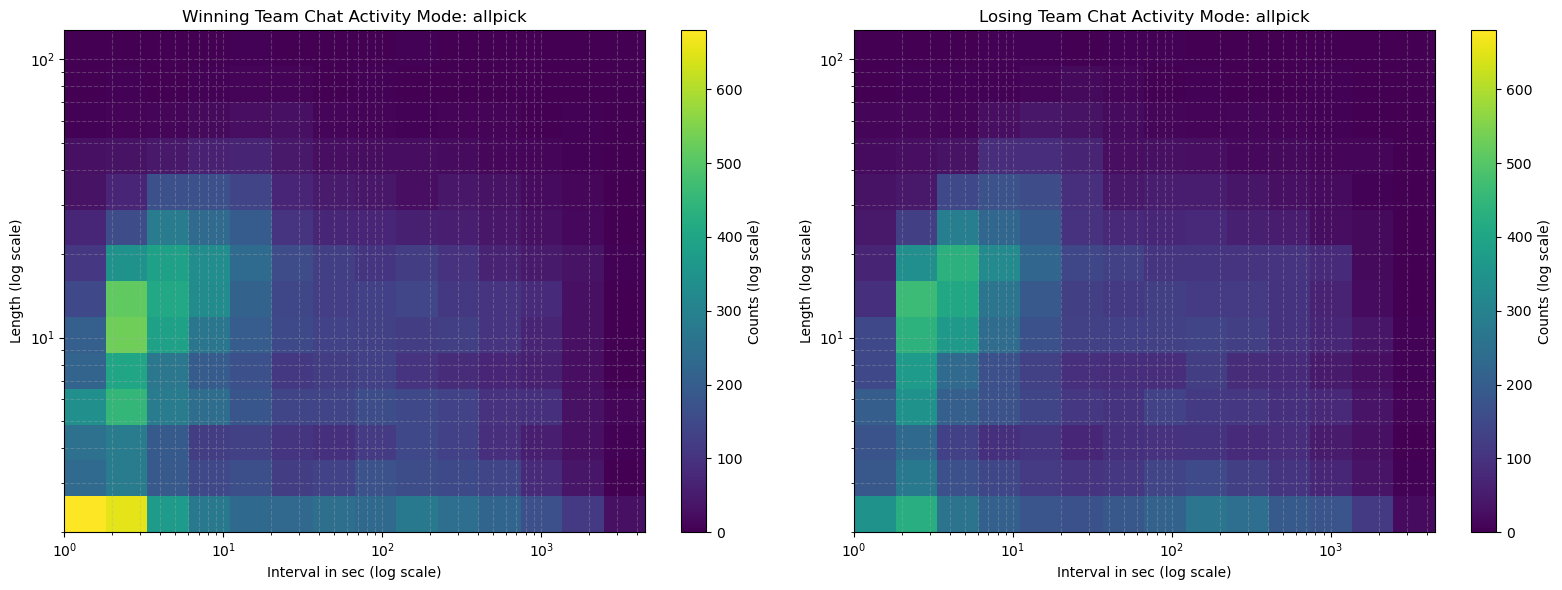

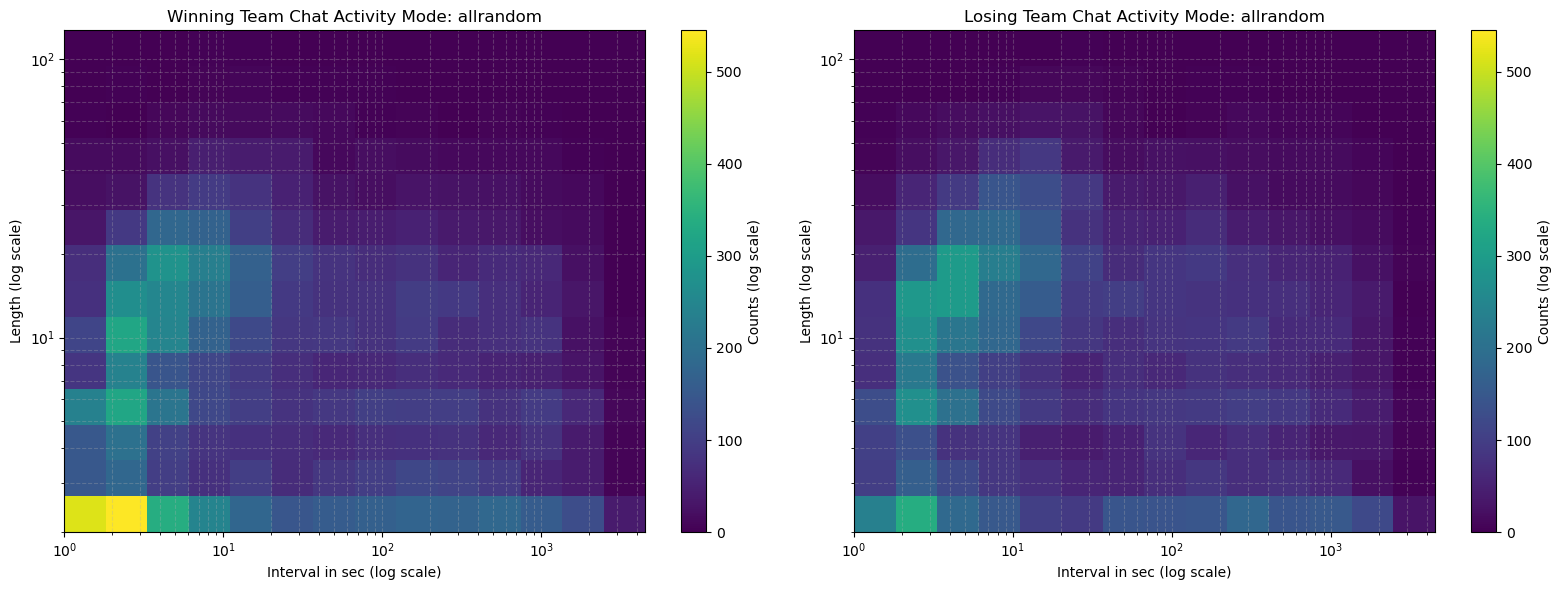

In [31]:
radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]
# count = 0

# winning_L = []
# losing_L = []

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:

        objs = json.load(file, object_hook=decimal_decoder)
    
    winning_sample = []
    losing_sample = []
    winning_L = []
    losing_L = []
    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        wining_diff = []
        losing_diff = []
        w, l = True, True
        if len(obj['chat']) > 1:
            
            for chat in obj['chat']:
                if 'slot' in list(chat.keys()):
                    if (chat['slot'] in radiant and obj['radiant_win']==True) or (chat['slot'] in dire and obj['radiant_win']==False):
                        winning_team_t.append(chat['time'])
                        # print('here')
                        if w == False:
                            winning_L.append(len(str(chat['key'])))
                        w = False
                    else:
                        losing_team_t.append(chat['time'])
                        if l == False:
                            losing_L.append(len(str(chat['key'])))
                        l = False
                    if len(winning_team_t)>1:
                        wining_diff = calculate_differences(winning_team_t)
                    if len(losing_team_t)>1:
                        losing_diff = calculate_differences(losing_team_t)
                count+=1
        winning_sample += wining_diff
        losing_sample += losing_diff
    
    # Compute histograms
    winning_heatmap, _, _ = np.histogram2d(winning_sample, winning_L, bins=[x_bins, y_bins])
    losing_heatmap, _, _ = np.histogram2d(losing_sample, losing_L, bins=[x_bins, y_bins])
    lim = np.max([np.max(winning_heatmap), np.max(losing_heatmap)])
    # Plot heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Winning team heatmap
    ax = axes[0]
    cax = ax.pcolormesh(x_bins, y_bins, winning_heatmap.T, shading='auto', cmap='viridis', norm=mcolors.Normalize(vmax=lim))
    fig.colorbar(cax, ax=ax, label='Counts (log scale)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Interval in sec (log scale)')
    ax.set_ylabel('Length (log scale)')
    ax.set_title('Winning Team Chat Activity Mode: %s'%mode_dict[mode])
    ax.grid(True, which='both', linestyle='--', alpha=0.3)

    # Losing team heatmap
    ax = axes[1]
    cax = ax.pcolormesh(x_bins, y_bins, losing_heatmap.T, shading='auto', cmap='viridis',norm=mcolors.Normalize(vmax=lim))
    fig.colorbar(cax, ax=ax, label='Counts (log scale)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Interval in sec (log scale)')
    ax.set_ylabel('Length (log scale)')
    ax.set_title('Losing Team Chat Activity Mode: %s'%mode_dict[mode])
    ax.grid(True, which='both', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.savefig(graph_root+'/heatmap_won&lost_tVl_%s.pdf'%(mode_dict[mode]))
    plt.show()